# PySINDy Performance W.R.T. Chaotic Level & Noisy Level

This notebook uses contour plots to demostrate the relationship of predicted model root-mean-square-error (RMSE) between chaotic level and noisy level. The chaotic level is measured by **Estimated Maximum Lyapunov Exponent** of each system and noisy level is measured by the **percentage of noise** added to the clean data.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

## Chaotic System Initialization

Precompute the time-series trajectory data of experimental systems and systems' attributes that describes the complexity of systems, including *Estimated Maximum Lyapunov Exponent*, *Kaplan Yorke Dimension*, *Multiscale Entropy*, and *Correlation Dimension*.

The dynamic systems used in this notebook are: 
             "Aizawa", "AnishchenkoAstakhov", "Arneodo", "Blasius", "Bouali", 
             "CaTwoPlus", "GenesioTesi", "HenonHeiles", "HyperBao", "HyperCai",
             "HyperJha", "HyperLorenz", "HyperLu", "HyperPang", "Laser",
             "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka".

In [53]:
# experimental system list
systems_list = ["Aizawa", "AnishchenkoAstakhov", "Arneodo", "Blasius", "Bouali", 
                "CaTwoPlus", "GenesioTesi", "HyperBao", "HyperCai",
                "HyperJha", "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka"]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "kaplan_yorke_dimension",
    "multiscale_entropy",
    "correlation_dimension",
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 2000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for equation_name in systems_list:
    eq = getattr(flows, equation_name)()
    try:
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)

## Algorithm 2 from Rudy et al. (2017) 
Algorithm 2 is implemented here for scanning the thresholds passed to the STLSQ optimizer (which actually defaults to Ridge Regression with the $l_0$ norm). This hyperparameter scanning is required if we are trying to fit many systems at once, which will have many different physical scales.

In [6]:
# Algorithm to scan over threshold values during Ridge Regression, and select
# highest performing model on the test set

def rudy_algorithm2(x_train, x_test, t_train, ode_lib, dtol, alpha=1e-5, 
                    tol_iter=25, change_factor=2, l0_pen=1e-3,
                    normalize_columns=True, optimizer_max_iter=20):  
    
    # Do an initial least-squares fit to get an initial guess of the coefficients
    optimizer = ps.STLSQ(threshold=0, alpha=0, 
                         max_iter=optimizer_max_iter, 
                         normalize_columns=normalize_columns, 
                         ridge_kw={'tol': 1e-10})
    
    # Compute initial model
    model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
    model.fit(x_train, t=t_train)
    
    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = l0_pen * np.linalg.cond(optimizer.Theta_)
    coef_best = optimizer.coef_
    
    # Compute MSE on the testing x_dot data (takes x_test and computes x_dot_test)
    error_best = model.score(x_test, metric=mean_squared_error, squared=False
                            ) + l0_penalty * np.count_nonzero(coef_best)
    
    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol
    
    # Loop over threshold values, note needs some coding 
    # if not using STLSQ optimizer
    for i in range(tol_iter):
        optimizer = ps.STLSQ(threshold=tol, alpha=alpha, 
                             max_iter=optimizer_max_iter,
                             normalize_columns=normalize_columns, 
                             ridge_kw={'tol': 1e-10})
        model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
        model.fit(x_train, t=t_train)
        coef_new = optimizer.coef_
        coef_history_[:, :, i + 1] = coef_new
        error_new = model.score(x_test, metric=mean_squared_error, squared=False
                               ) + l0_penalty * np.count_nonzero(coef_new)
        error_history_[i + 1] = error_new
        
        # If error improves, set the new best coefficients
        if error_new <= error_best:
            error_best = error_new
            coef_best = coef_new
            tol += dtol
            #tol *= change_factor
        else:
            #tol = tol / (change_factor * 1.1)
            tol = max(0, tol - change_factor * dtol)
            dtol = change_factor * dtol / (tol_iter - i)
            tol += dtol
    return coef_best, error_best, coef_history_, error_history_, model

## Reorder System List by Chaotic Level

Rearrange the name list of systems as y-axis label in contour plot.

In [11]:
# Obtain Lyapunov Exponent of each system
lyap_list = []
for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])

# Get reordered index
re_idx = np.argsort(lyap_list)

# Reorder systems list
re_sys_list = [systems_list[i] for i in re_idx]

## Compute Averaged RMSE WRT Different Noisy Level of Each System

Because of the randomness of noise added to the model, we take the average of the 10 RMSEs for each system to ensure the correctness and eliminate edge cases.

Notice that we ignore the extremely large RMSE, where typical RMSEs are about 1.0.

### Preparation

In [39]:
# Define helper method for mult-test
def multi_x_helper(x_train_added_noise, x_test, t_train, concat_library, 
                   max_iter, tol_iter):
    # rudy train
    coef_best, err_best, coef_history, err_history, model = rudy_algorithm2(
        x_train_added_noise, x_test, t_train,
        ode_lib=concat_library, dtol=1e-3,
        optimizer_max_iter=30,
        tol_iter=tol_iter,
        change_factor=2,
        l0_pen=1e-1
    )

    # compute predicted system
    x_dot_test = model.differentiate(x_test, t=t_test)
    x_dot_test_pred = model.predict(x_test)
    x_test_pred = model.simulate(x_test[0, :], t=t_test, integrator="odeint",
                                 integrator_kws={"mxstep":30})

    curr_x_rmse = mean_squared_error(x_test_pred, x_test, squared=False)
    curr_dot_rmse = mean_squared_error(x_dot_test_pred, x_dot_test, squared=False)
    
    return curr_x_rmse, curr_dot_rmse

In [19]:
# Define discovered parameters for particular models
parameter_dic = {"HenonHeiles":[15, 10], "HyperLorenz":[50, 3], "Rossler":[10, 4], "HyperBao":[30, 3]}

### Computation

In [ ]:
# data storages
noisy_levels = []
chaotic_levels = []
x_rmse_list = []
dot_rmse_list = []

# computation
for attractor_name in systems_list:
    print("-----------------------------------------------")
    print("--------------", attractor_name, "--------------")
    print("-----------------------------------------------")

    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    if attractor_name in parameter_dic:
        max_iter = parameter_dic[attractor_name][0]
        tol_iter = parameter_dic[attractor_name][1]
    else:
        max_iter = 30
        tol_iter = 15
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for denominator in range(10, 101, 10):
        temp_x = []
        temp_dot = []
        
        # multiple test for averaged results
        for j in range(10):
            x_train_noisy = x_train + np.random.normal(0, rmse / denominator, x_train.shape)
            
            poly_library = ps.PolynomialLibrary(degree=4)
            fourier_library = ps.FourierLibrary()
            concat_library = poly_library + fourier_library
            
            # computation
            curr_x, curr_dot = multi_x_helper(x_train_noisy, x_test, t_train, concat_library,
                                              max_iter, tol_iter)
            
            # check result
            if curr_x < 1e3:
                temp_x.append(curr_x)
            if curr_dot < 1e3:
                temp_dot.append(curr_dot)
                
        if (len(temp_x) > 0):
            # record result
            x_rmse_list.append(sum(temp_x) / len(temp_x))
            dot_rmse_list.append(sum(temp_dot) / len(temp_dot))
            noisy_levels.append(10 / denominator)
            chaotic_levels.append(all_properties[attractor_name]['maximum_lyapunov_estimated'])

-----------------------------------------------
-------------- Aizawa --------------
-----------------------------------------------
-----------------------------------------------
-------------- AnishchenkoAstakhov --------------
-----------------------------------------------
-----------------------------------------------
-------------- Arneodo --------------
-----------------------------------------------
-----------------------------------------------
-------------- Blasius --------------
-----------------------------------------------
-----------------------------------------------
-------------- Bouali --------------
-----------------------------------------------
-----------------------------------------------
-------------- CaTwoPlus --------------
-----------------------------------------------


/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.19935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.19935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.19935e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.38345e-19): result may not be accurate.
  return linalg.solve(A

-----------------------------------------------
-------------- GenesioTesi --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperBao --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperCai --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperJha --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperLorenz --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperLu --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperPang --------------
-----------------------------------------------
-----------------------------------------------
-

## Unstandardised Contour Plot

We plot 3 contour plots with different interpolation methods: `nearest` and `linear`. 

### X values

In [167]:
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

# make plot larger
plt.rcParams["figure.figsize"] = (20, 10)

In [180]:
## deal with tight y ticks
# preview ordered name list
print(re_sys_list)
print()
# preview y ticks positon values
print(re_lyap_list)

['AnishchenkoAstakhov', 'ShimizuMorioka', 'Blasius', 'Bouali', 'Rossler', 'Aizawa', 'GenesioTesi', 'Arneodo', 'HyperLorenz', 'HyperJha', 'MooreSpiegel', 'CaTwoPlus', 'HyperBao', 'Laser', 'LorenzBounded', 'HyperLu', 'Lorenz', 'HyperPang', 'HyperCai']

[0.03977755489021002, 0.044032234819090736, 0.047127554009157836, 0.04911273564448129, 0.07633013937806932, 0.08947878317195473, 0.09974381765927796, 0.24285661379003065, 0.2925643599949083, 0.3949499860671474, 0.4074353399833356, 0.5788123099350391, 0.6959739496471207, 0.7637435195473311, 0.8497533717540197, 1.0855770127041702, 1.0910931847726466, 1.586932998381499, 1.6344436239089568]


In [201]:
# rewrite y ticks
y_ticks = ['AnishchenkoAstakhov, Blasius,\n' + 'ShimizuMorioka, Bouali',
           'Rossler, Aizawa,\n' + 'GenesioTesi', 'Arneodo', 'HyperLorenz',
           'HyperJha\n' + 'MooreSpiegel', 'CaTwoPlus', 'HyperBao', 'Laser',
           'LorenzBounded', 'HyperLu,\n' + 'Lorenz', 'HyperPang', 'HyperCai'
          ]
          
# relocate y ticks
y_location = [sum(re_lyap_list[0:4]) / 4, sum(re_lyap_list[4:7]) / 3 + 0.02,
              re_lyap_list[7], re_lyap_list[8], sum(re_lyap_list[9:11]) / 2,
              re_lyap_list[11], re_lyap_list[12], re_lyap_list[13], re_lyap_list[14],
              sum(re_lyap_list[15:17]) / 2, re_lyap_list[17], re_lyap_list[18]
             ]

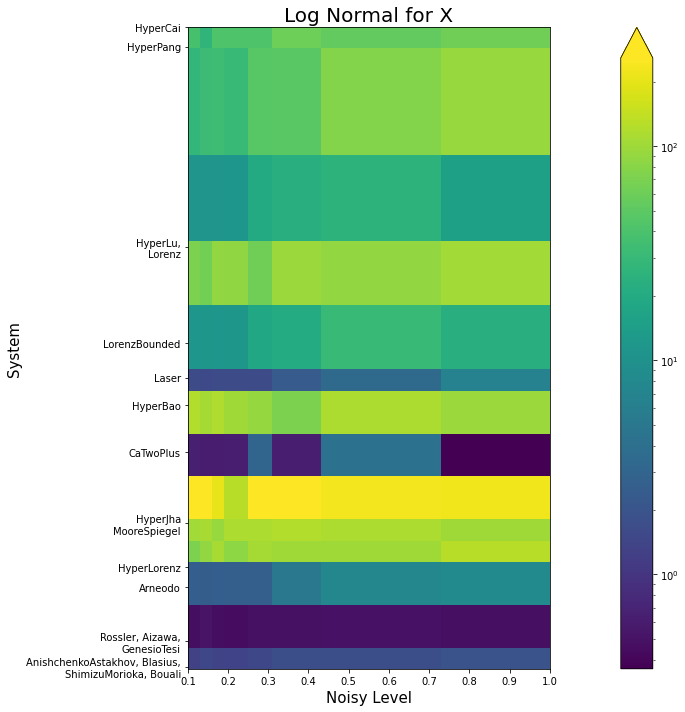

In [202]:
ax = plt.subplot()

# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 30),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 30))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy), method='nearest')

# visualize contour plot
im = ax.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

plt.colorbar(im, extend='max')

# add text descriptions
plt.title("Log Normal for X", fontsize=20)
plt.xlabel("Noisy Level", fontsize=15)
plt.ylabel("System", fontsize=15)

# replace y tick
ax.set_yticks(y_location)
ax.set_yticklabels(y_ticks)

plt.tight_layout()
plt.show()

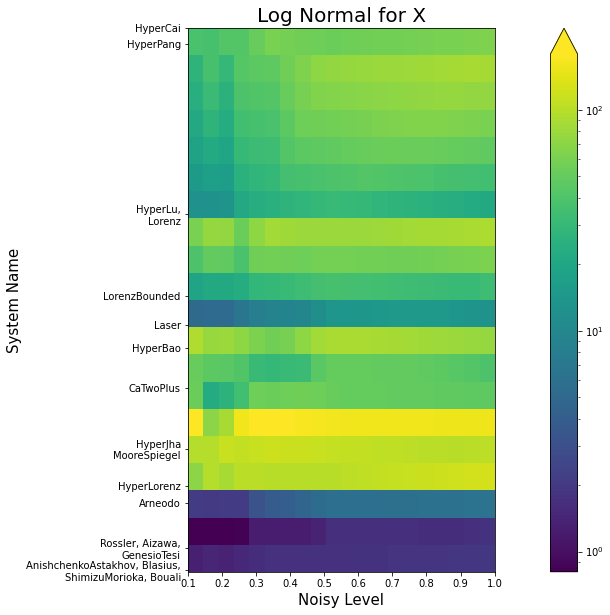

In [203]:
ax = plt.subplot()

# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 20),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 20))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy), method='linear')

# visualize contour plot
im = ax.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

plt.colorbar(im, extend='max')

# add text descriptions
plt.title("Log Normal for X", fontsize=20)
plt.xlabel("Noisy Level", fontsize=15)
plt.ylabel("System Name", fontsize=15)

# replace y tick
ax.set_yticks(y_location)
ax.set_yticklabels(y_ticks)

plt.show()

### X_dot values


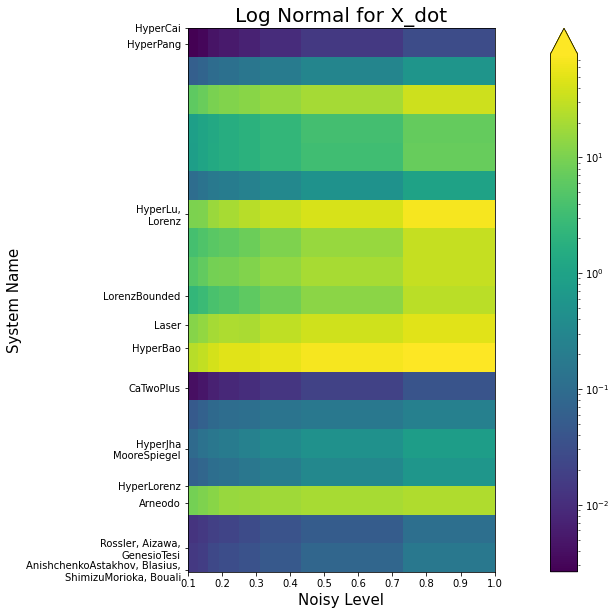

In [204]:
ax = plt.subplot()

# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 30),
                     lyap_list)
zz = griddata((noisy_levels, chaotic_levels), dot_rmse_list, (xx, yy), method='nearest')

# visualize contour plot
im = ax.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(lyap_list), np.amax(lyap_list)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

plt.colorbar(im, extend='max')

# add text descriptions
plt.title("Log Normal for X_dot", fontsize=20)
plt.xlabel("Noisy Level", fontsize=15)
plt.ylabel("System Name", fontsize=15)

# replace y tick
ax.set_yticks(y_location)
ax.set_yticklabels(y_ticks)

plt.show()

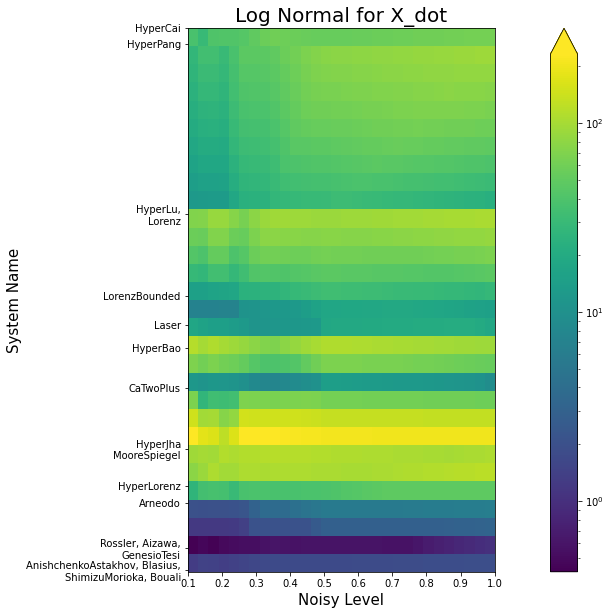

In [205]:
ax = plt.subplot()

# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 30),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 30))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy), method='linear')

# visualize contour plot
im = ax.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

plt.colorbar(im, extend='max')

# add text descriptions
plt.title("Log Normal for X_dot", fontsize=20)
plt.xlabel("Noisy Level", fontsize=15)
plt.ylabel("System Name", fontsize=15)

# replace y tick
ax.set_yticks(y_location)
ax.set_yticklabels(y_ticks)

plt.show()

## Standardised Contour Plot

Contour plots in the above section describe RMSE variations with respect to chaotic and noisy level. The RMSEs range from 0.01 to 100 or more. Thus, we standardise the RMSE for better observation of the variation trend.

In [ ]:
### Scale the RMSE 

## Chaotic Level vs RMSE Plot

In [145]:
# storage for 2D plot
mid_chaotic_list = []
mid_x_rmse_list = []
mid_dot_rmse_list = []

# retrieve middle value from each model
ini_index = 0
for attractor_name in systems_list:
    mid_x_rmse_list.append(sum(x_rmse_list[ini_index:ini_index+10]) / len(x_rmse_list[ini_index:ini_index+10]))
    mid_dot_rmse_list.append(sum(dot_rmse_list[ini_index:ini_index+10]) / len(dot_rmse_list[ini_index:ini_index+10]))
    mid_chaotic_list.append(all_properties[attractor_name]['maximum_lyapunov_estimated'])
    ini_index += 10

In [146]:
# sort by chaotic level
re_idx = np.argsort(mid_chaotic_list)

re_chaotic = [mid_chaotic_list for i in re_idx]
re_mid_x = [mid_x_rmse_list[i] for i in re_idx]
re_mid_dot = [mid_dot_rmse_list[i] for i in re_idx]

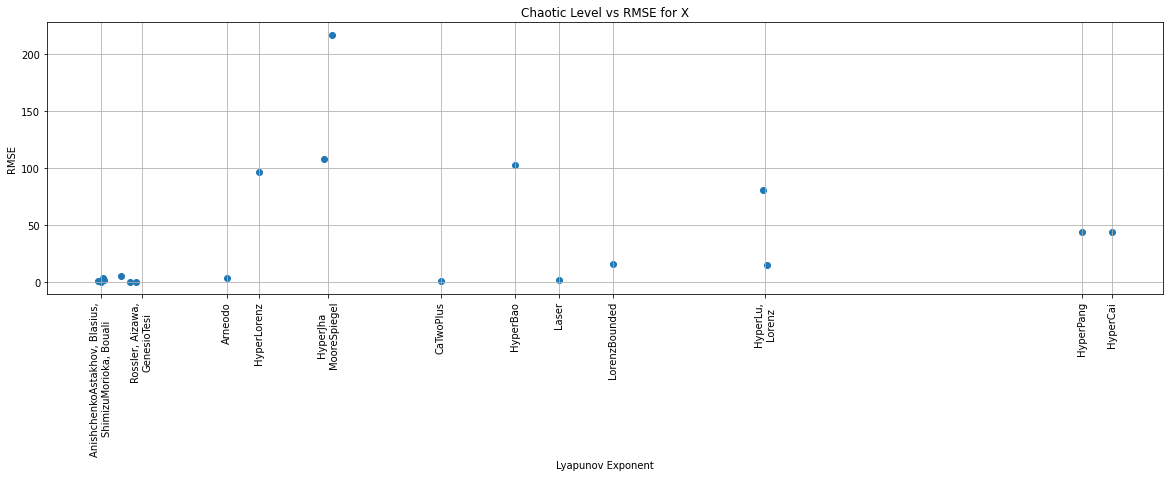

In [206]:
# X values
fig, ax = plt.subplots()
ax.scatter(mid_chaotic_list, mid_x_rmse_list)

# replace x tick
ax.set_xticks(y_location)
ax.set_xticklabels(y_ticks, rotation=90)

ax.grid()
ax.title.set_text('Chaotic Level vs RMSE for X')
ax.set_xlabel("Lyapunov Exponent", fontsize=10)
ax.set_ylabel("RMSE", fontsize=10)
fig.set_size_inches(20, 5)
plt.show()  

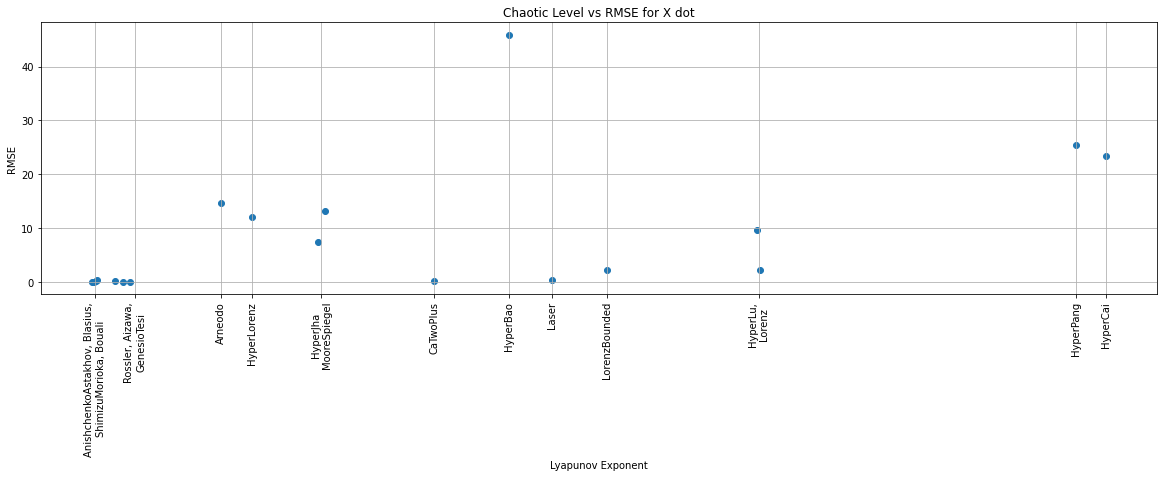

In [207]:
# X values
fig, ax = plt.subplots()
ax.scatter(mid_chaotic_list, mid_dot_rmse_list)
ax.grid()

# replace x tick
ax.set_xticks(y_location)
ax.set_xticklabels(y_ticks, rotation=90)

ax.title.set_text('Chaotic Level vs RMSE for X dot')
ax.set_xlabel("Lyapunov Exponent", fontsize=10)
ax.set_ylabel("RMSE", fontsize=10)
fig.set_size_inches(20, 5)
plt.show()  